In [2]:
import json
import copy
import numpy as np
import os
from tqdm import tqdm
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.data import MetadataCatalog, DatasetCatalog
from deepdisc.data_format.image_readers import DC2ImageReader, HSCImageReader#, RomanImageReader
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from deepdisc.astrodet.visualizer import ColorMode
from detectron2.structures import BoxMode
from deepdisc.astrodet.visualizer import Visualizer
from astropy.visualization import make_lupton_rgb
import multiprocessing as mp
from functools import partial

In [3]:
all_metadata_file = './lsst_data/annotations/all_metadata.json'
with open(all_metadata_file, 'r') as f:
    all_metadata = json.load(f)

In [4]:
reader = RomanImageReader()
all_metadata[1]

{'file_name': './lsst_data/truth/dc2_55.03_-41.9/full_c2_55.03_-41.9.npy',
 'image_id': 2,
 'height': 146,
 'width': 149,
 'subpatch': 'dc2_55.03_-41.9',
 'annotations': [{'obj_id': 0,
   'bbox': [140.5, 106.5, 13, 11],
   'area': 143,
   'bbox_mode': 1,
   'segmentation': [[146,
     111,
     145,
     112,
     145,
     113,
     146,
     114,
     149,
     114,
     150,
     113,
     150,
     112,
     149,
     111]],
   'category_id': 0,
   'redshift': 0.2305216424,
   'mag_r': 25.7139677586},
  {'obj_id': 2,
   'bbox': [75.5, 61.5, 11, 11],
   'area': 121,
   'bbox_mode': 1,
   'segmentation': [[80, 66, 80, 69, 83, 69, 83, 66]],
   'category_id': 0,
   'redshift': 0.520489881,
   'mag_r': 25.8481577515},
  {'obj_id': 3,
   'bbox': [123.5, 32.5, 9, 9],
   'area': 81,
   'bbox_mode': 1,
   'segmentation': [[128, 37, 128, 38, 129, 38, 129, 37]],
   'category_id': 0,
   'redshift': 0.5517941782,
   'mag_r': 26.7644538009},
  {'obj_id': 5,
   'bbox': [113.5, 38.5, 17, 17],
   '

In [5]:
# run this only if you want to plot new anns
red = np.array(colors.to_rgb('red'))*255
white = np.array(colors.to_rgb('white'))*255
blue = np.array(colors.to_rgb('blue'))*255
green = np.array(colors.to_rgb('green'))*255
astrotest_metadata = MetadataCatalog.get("astro_test").set(thing_classes=["galaxy", "star"]).set(thing_colors=[green, blue])

## Transforming Anns/Cutouts and Saving Both

In [17]:
# new anns need to have updated filename, height/width, annotations
# new truth need to have updated filenames, height/width, cutouts
def update_filename(old_lsst_filename, new_dir):
    return old_lsst_filename.replace('truth', new_dir)

def plot_new_anns(ddict, new_img, kind='HWC'):
    # to visualize transformed annotations
    if kind == 'CHW':
        b1 = new_img[2, :, :]
        b2 = new_img[1, :, :]
        b3 = new_img[0, :, :]        
    else:
        b1 = new_img[:, :, 2]
        b2 = new_img[:, :, 1]
        b3 = new_img[:, :, 0]        
    vis_img = make_lupton_rgb(b1, b2, b3, minimum=0, stretch=0.5, Q=10)
    v0 = Visualizer(
        vis_img,
        metadata=astrotest_metadata,
        scale=1,
        instance_mode=ColorMode.IMAGE,  # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    groundTruth = v0.draw_dataset_dict(ddict, lf=False, alpha=0.1, boxf=True)# boxf turns off  
    ax1 = plt.subplot(1, 1, 1)
    plt.figure(figsize=(7,7))
    ax1.imshow(groundTruth.get_image())

def transform(ddict, roman_im_filename, new_filename, kind="upsample", save_cutout=True):
    ddict = copy.deepcopy(ddict) # segmentation masks were causing problems with shallow copy  
    
    img = reader._read_image(ddict['file_name']) # changes to (Height, Width, Channels)
    lsst_shape = img.shape[:-1] # height, width
    
    roman_img = np.load(roman_im_filename)
    roman_shape = roman_img.shape[1:] # (Channels, Height, width)
    
    if kind == "pad":
        py = (roman_shape[0] - lsst_shape[0]) // 2  # height padding
        px = (roman_shape[1] - lsst_shape[1]) // 2  # width padding

        # handling odd dims
        py_extra = (roman_shape[0] - lsst_shape[0]) % 2
        px_extra = (roman_shape[1] - lsst_shape[1]) % 2

        # for PadTransform(https://detectron2.readthedocs.io/en/latest/modules/data_transforms.html#detectron2.data.transforms.PadTransform)
        x0 = px  # left padding
        y0 = py  # top padding
        x1 = px + px_extra  # right padding
        y1 = py + py_extra  # bottom padding
        transform_list = [
            T.PadTransform(x0, y0, x1, y1, pad_value=0, seg_pad_value=255)
        ]
    else:
        # from https://detectron2.readthedocs.io/en/latest/modules/data_transforms.html#detectron2.data.transforms.ResizeTransform
        # using bicubic instead of Lanczos interpolation as lanzcos is supported by
        # https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html#torch.nn.functional.interpolate which is what
        # detectron2 uses
        transform_list = [
            T.ResizeTransform(lsst_shape[0], lsst_shape[1], roman_shape[0], roman_shape[1], interp=Image.BICUBIC) 
        ]
    
    new_img, transforms = T.apply_transform_gens(transform_list, img)   
    annos = [
        utils.transform_instance_annotations(obj, transforms, new_img.shape[:-1])
        for obj in ddict.pop("annotations")
    ]
    # convert bboxes back to XYWH_ABS and set bbox_mode
    for ann in annos:
        bbox = BoxMode.convert(ann["bbox"].tolist(), BoxMode.XYXY_ABS, BoxMode.XYWH_ABS) # convert XYXY_ABS to XYWH_ABS
        ann["bbox"] = bbox
        ann["bbox_mode"] = 1
        ann["segmentation"] = [seg.tolist() for seg in ann['segmentation']] # to make it JSON serializable
    
    ddict["annotations"] = annos 
#     plot_new_anns(ddict, new_img)
    ddict["height"] = new_img.shape[:-1][0]
    ddict["width"] = new_img.shape[:-1][1]
    ddict["file_name"] = new_filename
    # annotations are fully updated now with this new cutout; they just need to be saved onto disk
    if save_cutout:
        # make sure to change back the axes of lsst_img so RomanImageReader can read it properly during training
        new_img = np.transpose(new_img, axes=(2, 0, 1)).astype(np.float32) # (channels, height, width)
        # combine roman with the new image
        combined_data = np.concatenate((new_img, roman_img), axis=0)
        np.save(new_filename, combined_data) # cutouts are saved onto disk
    else:
        pass
#         print("Combined cutouts already saved!")
    return ddict

def process_entry(entry, new_dir, save_cutout=True, kind="upsample"):
    old_lsst_filename = entry['file_name']
    new_filename = update_filename(old_lsst_filename, new_dir)
    roman_im_filename = old_lsst_filename.replace('./lsst_data/', './roman_data/')    
    new_ddict = transform(entry, roman_im_filename, new_filename, save_cutout=save_cutout, kind=kind)
    return new_ddict

def process_all_metadata(metadata, metadata_file, new_dir, save_cutout=True, kind="upsample"):
    num_cpus = 14
    pool = mp.Pool(processes=num_cpus)
    process_func = partial(process_entry, new_dir=new_dir, save_cutout=save_cutout, kind=kind)
    
    # slightly diff than before since using tqdm
    # use imap so we get an iter that tqdm can use
    new_metadata = list(tqdm(
        pool.imap(process_func, metadata),
        total=len(metadata),
        desc="Processing entries"
    ))
    
    pool.close() # close and join to make sure all processes are done and we're back on main
    pool.join()
    
    output_file = metadata_file.replace('annotations', 'annotations' + new_dir[5:])
    with open(output_file, 'w') as output_file:
        json.dump(new_metadata, output_file, indent=4)

# serial
# def process_all_metadata(metadata, metadata_file, new_dir, save_cutout=True):
#     new_metadata = []
#     for entry in tqdm(metadata, desc="Processing each entry"):
#         old_lsst_filename = entry['file_name']
# #         print(old_lsst_filename)
#         new_filename = update_filename(old_lsst_filename, new_dir)
# #         print(new_filename)
#         roman_im_filename = old_lsst_filename.replace('./lsst_data/', './roman_data/')    
#         new_ddict = transform(entry, roman_im_filename, new_filename, save_cutout)
# #         print(new_ddict)
#         new_metadata.append(new_ddict)
    
#     output_file = metadata_file.replace('annotations', 'annotationsc-ups')
# #     print(output_file)
#     with open(output_file, 'w') as output_file:
#         json.dump(new_metadata, output_file, indent=4)

## Upsampling with BICUBIC Interpolation

In [12]:
process_all_metadata(all_metadata, all_metadata_file, 'truthc-ups', save_cutout=False)

Processing entries: 100%|██████████| 3284/3284 [00:20<00:00, 156.81it/s]


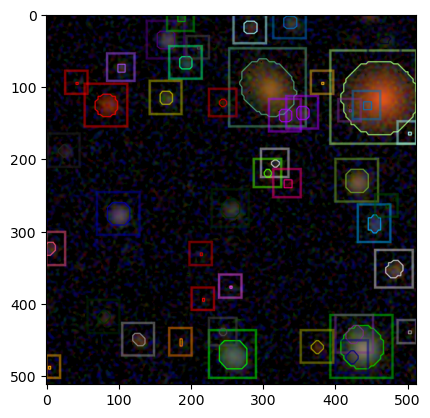

<Figure size 700x700 with 0 Axes>

In [15]:
file = './lsst_data/annotationsc-ups/all_metadata.json'
with open(file, 'r') as f:
    md = json.load(f)
img = np.load(md[2]['file_name'])
plot_new_anns(md[2], img, kind='CHW')

In [48]:
import json
import os
from tqdm import tqdm

# saving each subpatch's entries into its own JSON file
def process_metadata(metadata_file, output_dir):
    with open(metadata_file, 'r') as f:
        all_metadata = json.load(f)
    
    subpatch_dict = {}
    # grouping entries by subpatch
    for entry in tqdm(all_metadata, desc="Grouping by subpatch"):
        subpatch = entry['subpatch']
        if subpatch not in subpatch_dict:
            subpatch_dict[subpatch] = []
        subpatch_dict[subpatch].append(entry)
    
    # save each subpatch's entries to disk
    for subpatch, entries in subpatch_dict.items():
        output_file_path = os.path.join(output_dir, f"{subpatch}.json")
        with open(output_file_path, 'w') as output_file:
            json.dump(entries, output_file, indent=4)

In [ ]:
process_metadata('./lsst_data/annotationsc-ups/all_metadata.json', './lsst_data/annotationsc-ups')

In [22]:
# saving updated train, val, test
test = './lsst_data/annotations/test.json'
train = './lsst_data/annotations/train.json'
val = './lsst_data/annotations/val.json'
with open(test, 'r') as f:
    testmd = json.load(f)
with open(train, 'r') as f:
    trainmd = json.load(f)
with open(val, 'r') as f:
    valmd = json.load(f)

In [13]:
process_all_metadata(testmd, test, 'truthc-ups', save_cutout=False)

Processing each entry: 100%|██████████| 658/658 [01:32<00:00,  7.11it/s]


In [18]:
process_all_metadata(valmd, val, 'truthc-ups', save_cutout=False)

Processing entries: 100%|██████████| 328/328 [00:02<00:00, 156.31it/s]


In [19]:
process_all_metadata(trainmd, train, 'truthc-ups', save_cutout=False)

Processing entries: 100%|██████████| 2298/2298 [00:13<00:00, 172.62it/s]


### Saving Truth Info

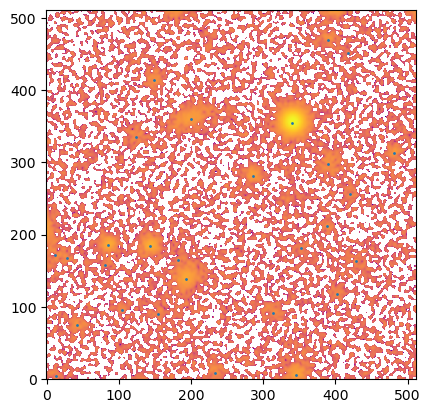

In [26]:
# plotting the r filter and corresponding xs and ys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
with open('lsst_data/annotations/dc2_50.93_-42.0.json', 'r') as f:
    old = json.load(f)
with open('lsst_data/annotationsc-ups/dc2_50.93_-42.0.json', 'r') as f:
    data = json.load(f)
old_d1 = old[2]
d1 = data[2]
img = np.load(d1['file_name'])[2, :, :]
imgid = d1['image_id']
truth_cat = None
with open(f"lsst_data/truth/{d1['subpatch']}/{d1['subpatch']}_info.json", 'r') as f:
    all_truth_info = json.load(f)
    truth_cat = [truth_info['obj_catalog'] for truth_info in all_truth_info if truth_info['image_id'] == imgid]
truth_cat = pd.read_json(truth_cat[0])
plt.imshow(img,norm=colors.LogNorm(), cmap='plasma', origin='lower')
# plt.axis('off')
scale_y = 512 / old_d1['height']
scale_x = 512 / old_d1['width']
xs = scale_x * truth_cat.new_x.values
ys = scale_y * truth_cat.new_y.values
plt.scatter(xs,ys,s=1)

As such, we must also change the xs and ys based on the scale factor that we used to upsample.

In [54]:
import os
import json
import copy

def process_subpatch_info(truth_dir, new_dir, kind="ups"):
    for root, dirs, files in os.walk(truth_dir):
        for file in files:
            if file.endswith('_info.json'):
                file_path = os.path.join(root, file)
#                 print(file_path)
                with open(file_path, 'r') as f:
                    data = json.load(f)
                new_data = copy.deepcopy(data)
                truth_cat = [truth_info['obj_catalog'] for truth_info in all_truth_info if truth_info['image_id'] == imgid]
                for entry in new_data:
                    entry['file_name'] = entry['file_name'].replace('truth', new_dir)
                    old_shape = (entry['height'], entry['width'])
                    entry['height'] = 512
                    entry['width'] = 512
                    cat = pd.read_json(entry['obj_catalog'])
                    if kind == "pad":
                        py = (512 - old_shape[0]) // 2  # height padding
                        px = (512 - old_shape[1]) // 2  # width padding
                        cat['new_x'] = cat['new_x'] + px
                        cat['new_y'] = cat['new_y'] + py                        
                    else:
                        scale_y = 512 / old_shape[0]
                        scale_x = 512 / old_shape[1]
                        cat['new_x'] = scale_x * cat['new_x']
                        cat['new_y'] = scale_y * cat['new_y']
                    entry['obj_catalog'] = cat.to_json(orient='records')
                
                new_root = root.replace('truth', new_dir)
#                 print(os.path.join(new_root, file))
                new_file_path = os.path.join(new_root, file)
                with open(new_file_path, 'w') as f:
                    json.dump(new_data, f, indent=4)

In [ ]:
truth_dir = './lsst_data/truth'
new_dir = 'truthc-ups'
process_subpatch_info(truth_dir, new_dir)

### Verifying our new_x and new_y's are transformed

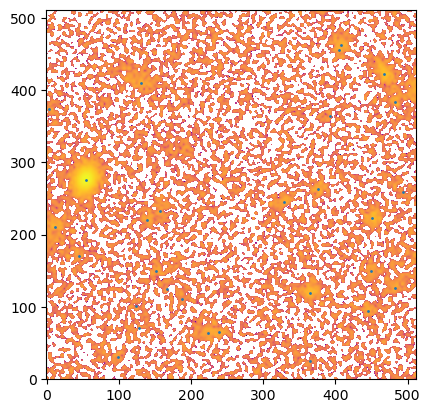

In [43]:
# plotting the r filter and corresponding xs and ys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
with open('lsst_data/annotationsc-ups/dc2_50.93_-42.0.json', 'r') as f:
    data = json.load(f)

d1 = data[4]
img = np.load(d1['file_name'])[2, :, :]
imgid = d1['image_id']
truth_cat = None
with open(f"lsst_data/truthc-ups/{d1['subpatch']}/{d1['subpatch']}_info.json", 'r') as f:
    all_truth_info = json.load(f)
    truth_cat = [truth_info['obj_catalog'] for truth_info in all_truth_info if truth_info['image_id'] == imgid]

    truth_cat = pd.read_json(truth_cat[0])
plt.imshow(img,norm=colors.LogNorm(), cmap='plasma', origin='lower')
# plt.axis('off')
plt.scatter(truth_cat.new_x.values,truth_cat.new_y.values,s=1)

## Just adding Padding

In [18]:
process_all_metadata(all_metadata, all_metadata_file, 'truthc-pad', kind="pad")

Processing entries: 100%|██████████| 3284/3284 [00:07<00:00, 430.26it/s]


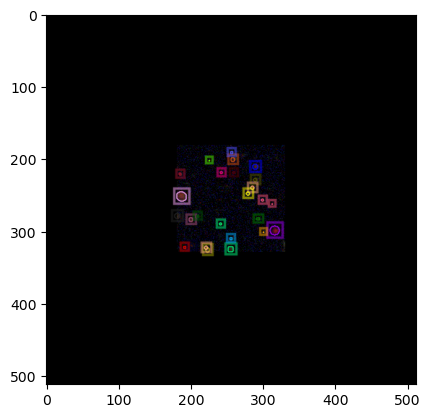

<Figure size 700x700 with 0 Axes>

In [45]:
file = './lsst_data/annotationsc-pad/all_metadata.json'
with open(file, 'r') as f:
    md = json.load(f)
img = np.load(md[4]['file_name'])
plot_new_anns(md[4], img, kind='CHW')

In [21]:
# saving each subpatch's entries into its own JSON file
process_metadata('./lsst_data/annotationsc-pad/all_metadata.json', './lsst_data/annotationsc-pad')

Grouping by subpatch: 100%|██████████| 3284/3284 [00:00<00:00, 1297117.84it/s]


In [23]:
process_all_metadata(testmd, test, 'truthc-pad', save_cutout=False)

Processing entries: 100%|██████████| 658/658 [00:04<00:00, 158.86it/s]


In [24]:
process_all_metadata(valmd, val, 'truthc-pad', save_cutout=False)

Processing entries: 100%|██████████| 328/328 [00:02<00:00, 155.74it/s]


In [25]:
process_all_metadata(trainmd, train, 'truthc-pad', save_cutout=False)

Processing entries: 100%|██████████| 2298/2298 [00:14<00:00, 161.38it/s]


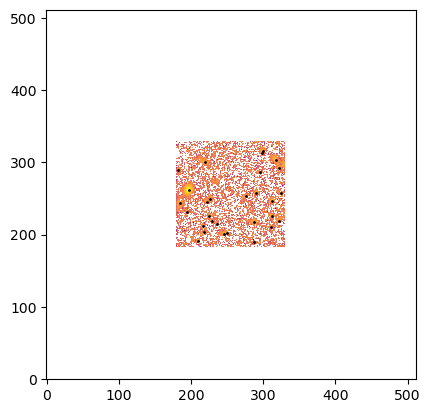

In [44]:
# plotting the r filter and corresponding xs and ys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
with open('lsst_data/annotations/dc2_50.93_-42.0.json', 'r') as f:
    old = json.load(f)
with open('lsst_data/annotationsc-pad/dc2_50.93_-42.0.json', 'r') as f:
    data = json.load(f)
old_d1 = old[4]
d1 = data[4]
img = np.load(d1['file_name'])[2, :, :]
imgid = d1['image_id']
truth_cat = None
with open(f"lsst_data/truth/{d1['subpatch']}/{d1['subpatch']}_info.json", 'r') as f:
    all_truth_info = json.load(f)
    truth_cat = [truth_info['obj_catalog'] for truth_info in all_truth_info if truth_info['image_id'] == imgid]
truth_cat = pd.read_json(truth_cat[0])
plt.imshow(img,norm=colors.LogNorm(), cmap='plasma', origin='lower')
# plt.axis('off')
py = (512 - old_d1['height']) // 2  # height padding
px = (512 - old_d1['width']) // 2  # width padding
xs = truth_cat.new_x.values + px
ys = truth_cat.new_y.values + py 
plt.scatter(xs, ys, s=1, color='k')

As such, we must also change the xs and ys based on the padding. We just need to center them specifically.

In [55]:
truth_dir = './lsst_data/truth'
new_dir = 'truthc-pad'
process_subpatch_info(truth_dir, new_dir, kind="pad")

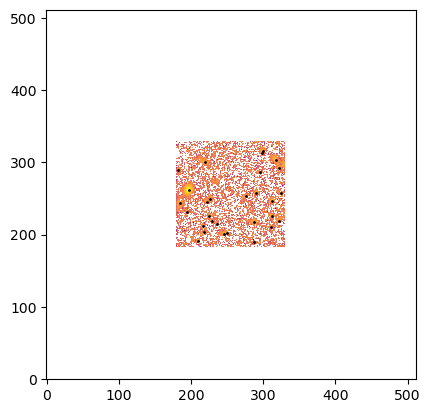

In [56]:
# plotting the r filter and corresponding xs and ys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
with open('lsst_data/annotationsc-pad/dc2_50.93_-42.0.json', 'r') as f:
    data = json.load(f)

d1 = data[4]
img = np.load(d1['file_name'])[2, :, :]
imgid = d1['image_id']
truth_cat = None
with open(f"lsst_data/truthc-pad/{d1['subpatch']}/{d1['subpatch']}_info.json", 'r') as f:
    all_truth_info = json.load(f)
    truth_cat = [truth_info['obj_catalog'] for truth_info in all_truth_info if truth_info['image_id'] == imgid]

    truth_cat = pd.read_json(truth_cat[0])
plt.imshow(img,norm=colors.LogNorm(), cmap='plasma', origin='lower')
# plt.axis('off')
plt.scatter(truth_cat.new_x.values,truth_cat.new_y.values,s=1, color='k')

In [3]:
im = np.load('/home/shared/hsc/roman_lsst/lsst_data/truthc-ups/dc2_51.53_-40.0/full_c103_51.53_-40.0.npy')

In [4]:
im.shape

(10, 512, 512)